## Baseline Model: Logistic Resgression

Since the features in the dataset are mostly numeric and after a small amount of preprosessing the data is clean and well structured, a Logistic Regression as our baseline is the most compelling model, as it is easily interpretable, and tends to preform well with numeric tablular data

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load dataset
data = pd.read_csv("./datasets/cs-training.csv")

# Clean data
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

# Separate features and target
x = data.drop(columns=["SeriousDlqin2yrs"])
y = data["SeriousDlqin2yrs"]

# Impute missing values
imputer = SimpleImputer(strategy='median')
x_imputed = imputer.fit_transform(x)

# Scale the input features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_imputed)

# Intialize/fit the model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_scaled, y)

# Step 4: Print learned parameters
print("Classes:", logreg.classes_)
print("Intercept:", logreg.intercept_)
print("Coefficients:", logreg.coef_)

Classes: [0 1]
Intercept: [-2.85870261]
Coefficients: [[-0.00927033 -0.42024756  2.09670562 -0.05433176 -0.46544451 -0.03920628
   1.92563693  0.07687589 -3.86375553  0.10608246]]


## Evaluation Metrics

The most appropriate evaluation metrics for the classification task are: AUC, F1-score and Recall.
Recall and F1-score are appropriate preformance metrics for our model because they provide a more realistic view than accuracy alone, since our data has a heavy imbalance towards False or 0 values. AUC is also an appropriate metric because it is able to measure how well the model is distinguishing between the two classes across all thresholds, and it stays reliable with imbalanced data.

## Train-Valiation Splits

original dataset: 150000 
train_data 120000 
validation_data 30000
Validation Performance Metrics:
Recall   : 0.670
F1-score : 0.286
ROC AUC  : 0.802


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


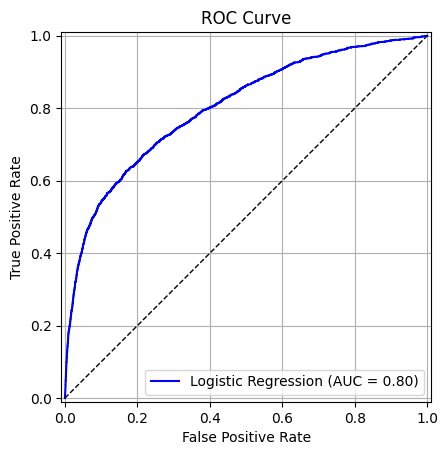

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Split data (80% train, 20% validation) w/ Stratification
x_train, x_val, y_train, y_val = train_test_split(x_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Display data split
print(
    'original dataset:', len(data),
    '\ntrain_data', len(x_train),
    '\nvalidation_data', len(x_val)
)

# Scaling
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Logistic Regression model
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(x_train_scaled, y_train)

# Predictions
y_pred = logreg.predict(x_val_scaled)
y_prob = logreg.predict_proba(x_val_scaled)[:, 1]

# Evaluation metrics
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)

# Display evaluation metrics
print("Validation Performance Metrics:")
print(f"Recall   : {recall:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC AUC  : {auc:.3f}")

# Plot ROC curve using RocCurveDisplay
RocCurveDisplay.from_predictions(y_val, y_prob, name='Logistic Regression', color='blue')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1)  
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()


## Baseline Interpretations

- AUC = 0.80 means that the logistic regression baseline is moderately successful at seperating the two classes
- Recall = 0.670 means the model is good at identifying most of the True or 1 values, However,
- F1-score = 0.286 also suggests the model produces many false positives as the model struggles to balance precision and recall

From this information and the understanding that logisitic regression is a simple, linear model, it can be observed that our baseline has high bias and low variance. The high bias and low variance in our baseline indicates the model is underfitting the data. However, since its AUC value is not extremely low, The model is believed to be only slightly underfitting as it is still able to generalize well to unseen data.    



### Cross Validation

In [31]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, recall_score, f1_score
import numpy as np


# stratified cross validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# metrics
scoring = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# perform cross-validation
logreg_cv = LogisticRegression(max_iter=1000, class_weight='balanced')
cv_results = cross_validate(
    logreg_cv,
    x_scaled, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# mean and standard deviation for each metric
print("Cross Validation Performance Metrics (mean ± std): ")
for metric in scoring.keys():
    mean = np.mean(cv_results[f'test_{metric}'])
    std = np.std(cv_results[f'test_{metric}'])
    print(f"{metric:8}:  {mean:.3f} ± {std:.3f}")


Cross Validation Performance Metrics (mean ± std): 
recall  :  0.652 ± 0.007
f1      :  0.273 ± 0.002
roc_auc :  0.791 ± 0.004


# Interpration of Cross Validation Results

We chose a Stratified K Fold since the dataset is imbalanced, this ensures proper representation of both classes in all folds.

**Cross Validation Results:**  
Recall   :  0.652 ± 0.007   
F1-score :  0.273 ± 0.002   
ROC AUC  :  0.791 ± 0.004  

**Compared to Baseline:**  
Recall   : 0.670  
F1-score : 0.286  
ROC AUC  : 0.802  

The relatively low standard deviation shows that results are generally consistent across folds. This supports the earlier claim that the model has low variance and generalizes well to new data. 

The model appears to be stable as the metrics closely resemble the results of the baseline model. Given that the results are very similar to the initial metrics, we can still conclude that the model has high bias and is slightly underfitting.

Overall, these results show the baseline model generalizes well but further improvements should be made to reduce bias.

